In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import numpy as np
import time
import matplotlib.pyplot as plt
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Hyperparameters
num_epochs = 10
batch_size = 32
learning_rate = 1e-3

In [4]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to fit model expected input
    transforms.ToTensor(),           # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize for pre-trained models
])

train_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/CS485/train', transform=transform)
val_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/CS485/val', transform=transform)
test_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/CS485/test', transform=transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

### visualize train images

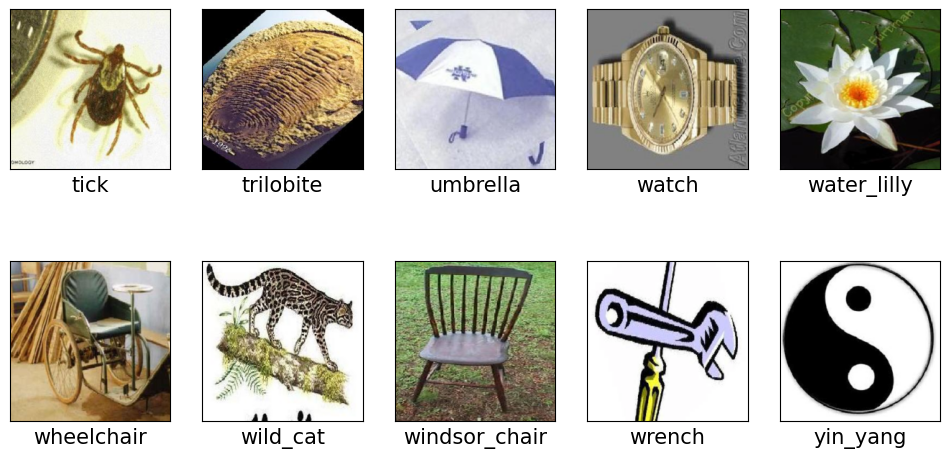

In [ ]:
# Denormalize function
def denormalize(image):
    mean = torch.tensor([0.485, 0.456, 0.406])
    std = torch.tensor([0.229, 0.224, 0.225])
    image = image * std[:, None, None] + mean[:, None, None]
    return image

# Get a batch of data
images, labels = next(iter(train_loader))

img_idx = []
for label in range(10):
    for i in labels:
        if i == label:
            img_idx.append(labels.tolist().index(i))
            break

classes = ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
classes = sorted(classes)
fig, axes = plt.subplots(2, 5, figsize=(12, 6))

i = 0
for row in axes:
  for axis in row:
    axis.set_xticks([])
    axis.set_yticks([])
    axis.set_xlabel(classes[i], fontsize=15)
    img = denormalize(images[img_idx[i]]).permute(1, 2, 0)
    axis.imshow(img)
    i += 1

### visualize test images

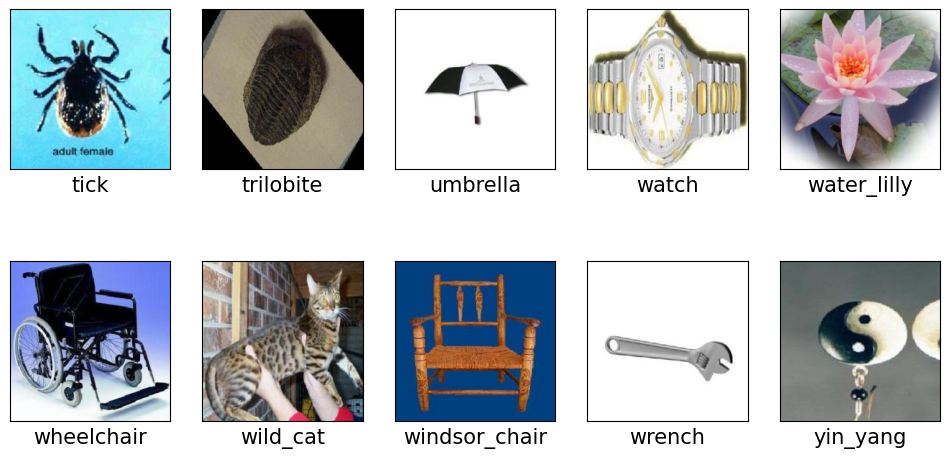

In [ ]:
# Denormalize function
def denormalize(image):
    mean = torch.tensor([0.485, 0.456, 0.406])
    std = torch.tensor([0.229, 0.224, 0.225])
    image = image * std[:, None, None] + mean[:, None, None]
    return image

# Get a batch of data
images, labels = next(iter(test_loader))

img_idx = []
for label in range(10):
    for i in labels:
        if i == label:
            img_idx.append(labels.tolist().index(i))
            break

classes = ['water_lilly', 'trilobite', 'wild_cat', 'wrench', 'wheelchair', 'yin_yang', 'umbrella', 'watch', 'windsor_chair', 'tick']
classes = sorted(classes)
fig, axes = plt.subplots(2, 5, figsize=(12, 6))

i = 0
for row in axes:
  for axis in row:
    axis.set_xticks([])
    axis.set_yticks([])
    axis.set_xlabel(classes[i], fontsize=15)
    img = denormalize(images[img_idx[i]]).permute(1, 2, 0)
    axis.imshow(img)
    i += 1

### model

In [9]:
class ConvNet(nn.Module):
    # initialize the class and the parameters
    def __init__(self):
        super(ConvNet, self).__init__()

        # convolutional layer 1 & max pool layer 1
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3),
            nn.MaxPool2d(kernel_size=2))

        # convolutional layer 2 & max pool layer 2
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=4),
            nn.MaxPool2d(kernel_size=2))

        #Fully connected layer
        self.fc = nn.Linear(32*54*54, 10)


    # Feed forward the network
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

model = ConvNet()
model.to(device)
print(model)

ConvNet(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(4, 4), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=93312, out_features=10, bias=True)
)


### train

In [14]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_hist, acc_hist = [], []
loss_hist_val, acc_hist_val = [], []

for epoch in range(10):
  running_loss = 0.0
  correct = 0
  total = 0
  for data in train_loader:
    batch, labels = data
    batch, labels = batch.to(device), labels.to(device)
    optimizer.zero_grad()
    outputs = model(batch)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    _, predicted = torch.max(outputs, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    running_loss += loss.item()

  avg_loss = running_loss / total
  avg_acc = correct / total
  loss_hist.append(avg_loss)
  acc_hist.append(avg_acc)

  model.eval()
  loss_val = 0.0
  correct_val = 0
  total_val = 0

  with torch.no_grad():
    for data in test_loader:
      batch, labels = data
      batch, labels = batch.to(device), labels.to(device)
      outputs = model(batch)
      loss = criterion(outputs, labels)
      _, predicted = torch.max(outputs, 1)
      correct_val += (predicted == labels).sum().item()
      loss_val += loss.item()
    avg_loss_val = loss_val / len(test_dataset)
    avg_acc_val = correct_val / len(test_dataset)
    loss_hist_val.append(avg_loss_val)
    acc_hist_val.append(avg_acc_val)
  model.train()
  print('[epoch %d] loss: %.5f accuracy: %.4f   val loss: %.5f val accuracy: %.4f' % (epoch + 1, avg_loss, avg_acc, avg_loss_val, avg_acc_val))

[epoch 1] loss: 0.00119 accuracy: 0.9936   val loss: 0.24417 val accuracy: 0.5449
[epoch 2] loss: 0.00084 accuracy: 0.9936   val loss: 0.17136 val accuracy: 0.6154
[epoch 3] loss: 0.00036 accuracy: 0.9873   val loss: 0.21170 val accuracy: 0.5705
[epoch 4] loss: 0.00402 accuracy: 0.9682   val loss: 0.18233 val accuracy: 0.5513
[epoch 5] loss: 0.00164 accuracy: 0.9873   val loss: 0.24529 val accuracy: 0.4808
[epoch 6] loss: 0.00063 accuracy: 0.9809   val loss: 0.27171 val accuracy: 0.5577
[epoch 7] loss: 0.00170 accuracy: 0.9809   val loss: 0.24816 val accuracy: 0.5641
[epoch 8] loss: 0.00020 accuracy: 0.9936   val loss: 0.30788 val accuracy: 0.5128
[epoch 9] loss: 0.00121 accuracy: 0.9873   val loss: 0.34437 val accuracy: 0.4744
[epoch 10] loss: 0.00148 accuracy: 0.9936   val loss: 0.29906 val accuracy: 0.5256


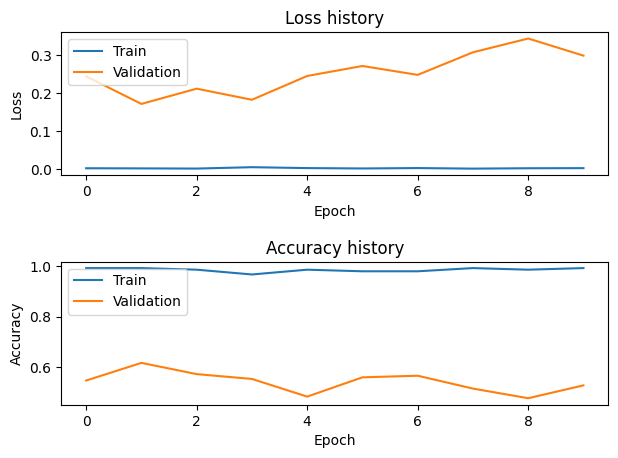

In [19]:
legend = ['Train', 'Validation']
fig, ax = plt.subplots(2, 1)

plt.subplot(2, 1, 1)
plt.plot(loss_hist, label='train')
plt.plot(loss_hist_val, label='val')
plt.title('Loss history')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(legend, loc='upper left')

fig.tight_layout(pad=1.5)

plt.subplot(2, 1, 2)
plt.plot(acc_hist, label='train')
plt.plot(acc_hist_val, label='val')
plt.title('Accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

fig.tight_layout(pad=1.5)

plt.legend(legend, loc='upper left')
plt.show()


### test

In [20]:
pred_vec = []
correct = 0
model.eval()
with torch.no_grad():
    for data in test_loader:
        batch, labels = data
        batch, labels = batch.to(device), labels.to(device)
        outputs = model(batch)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        pred_vec.append(predicted)
    pred_vec = torch.cat(pred_vec)

print('Accuracy on the 10000 test images: %.2f %%' % (100 * correct / len(test_dataset)))

Accuracy on the 10000 test images: 52.56 %
